In [1]:
import functools
import os
import shutil
import sys
from time import time
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
from estimagic import minimize
from estimagic.optimization.process_constraints import process_constraints
from sid import get_msm_func, get_simulate_func
from sid.msm import get_diag_weighting_matrix

from src.calculate_moments import (
    smoothed_outcome_per_hundred_thousand_rki,
    smoothed_outcome_per_hundred_thousand_sim,
)
from src.config import BLD, SRC
from src.contact_models.get_contact_models import get_all_contact_models
from src.create_initial_states.create_initial_conditions import (  # noqa
    create_initial_conditions,
)
from src.manfred.minimize_manfred_estimagic import minimize_manfred_estimagic
from src.manfred.shared import hash_array
from src.plotting.plot_msm_performance import plot_msm_performance
from src.plotting.policy_gantt_chart import make_gantt_chart_of_policy_dict
from src.policies.full_policy_blocks import (
    get_german_reopening_phase,
    get_hard_lockdown,
    get_only_educ_closed,
    get_soft_lockdown,
)
from src.policies.policy_tools import combine_dictionaries
from estimagic.batch_evaluators import joblib_batch_evaluator
from estimagic.visualization.colors import get_colors
import matplotlib.pyplot as plt


def _get_free_params(params, constraints):
    pc, pp = process_constraints(constraints, params)
    return pp.query("_internal_free")

In [2]:
ESTIMATION_START = pd.Timestamp("2020-10-01")
ESTIMATION_END = pd.Timestamp("2020-12-10")

INIT_START = ESTIMATION_START - pd.Timedelta(31, unit="D")
INIT_END = ESTIMATION_START - pd.Timedelta(1, unit="D")
initial_states = pd.read_parquet(BLD / "data" / "initial_states.parquet")
share_known_cases = pd.read_pickle(
    BLD / "data" / "processed_time_series" / "share_known_cases.pkl"
)

In [3]:
initial_conditions = create_initial_conditions(
    start=INIT_START, end=INIT_END, seed=3484, reporting_delay=5,
)

In [4]:
contact_models = get_all_contact_models()

In [5]:
def plot_msm_performance(iteration):
    """Plot the moment performance contrasting empirical and simulated moments.
    Args:
        iteration (dict): estimagic optimization iteration
    Returns:
        fig, axes
    """
    colors = get_colors(palette="categorical", number=2)

    fig, axes = plt.subplots(nrows=6, figsize=(8, 16), sharex=False)

    key = "infections_by_age_group"

    emp_mom = _convert_to_dataframe_with_age_groups_as_columns(
        iteration["empirical_moments"][key]
    )
    sim_mom = [mom[key] for mom in iteration["simulated_moments"]]
    mean_sim_mom = _convert_to_dataframe_with_age_groups_as_columns(
        pd.concat(sim_mom, axis=1).mean(axis=1)
    )

    age_groups = ["0-4", "5-14", "15-34", "35-59", "60-79", "80-100"]

    for age_group, ax in zip(age_groups, axes):
        for mom in sim_mom:
            mom_df = _convert_to_dataframe_with_age_groups_as_columns(mom)
            sns.lineplot(
                x=mom_df.index,
                y=mom_df[age_group],
                color=colors[0],
                alpha=0.4,
                linewidth=0.8,
                ax=ax,
            )
        sns.lineplot(
            x=mean_sim_mom.index,
            y=mean_sim_mom[age_group],
            label="simulated",
            color=colors[0],
            ax=ax,
            linewidth=2.5,
        )

        sns.lineplot(
            x=emp_mom.index,
            y=emp_mom[age_group],
            label="empirical",
            color=colors[1],
            ax=ax,
            linewidth=2.5,
        )
        ax.set_title(f"Goodness of Fit: {age_group}")
        ax.set_ylabel("Infections per 100 000")

    for ax in axes:
        ax.xaxis.set_major_locator(plt.MaxNLocator(5))

    fig.tight_layout()

    return fig, axes


def _convert_to_dataframe_with_age_groups_as_columns(sr):
    sr = sr.copy()
    sr.name = "value"
    df = sr.to_frame()
    df["date"] = list(map(lambda x: x.split("'", 2)[1], df.index))
    df["date"] = pd.to_datetime(df["date"])
    df["group"] = list(map(lambda x: x.rsplit(",", 1)[1].strip("') "), df.index))
    df.set_index(["date", "group"], inplace=True)
    return df["value"].unstack()



In [6]:
def parallelizable_msm_func(
    params, initial_states, initial_conditions, prefix, share_known_cases, seed,
):

    params_hash = hash_array(params["value"].to_numpy())
    path = SRC / "exploration" / f"{prefix}_{params_hash}_{os.getpid()}"

    contact_models = get_all_contact_models()

    estimation_policies = get_estimation_policies(contact_models)

    simulate = get_simulate_func(
        params=params,
        initial_states=initial_states,
        contact_models=contact_models,
        contact_policies=estimation_policies,
        duration={"start": ESTIMATION_START, "end": ESTIMATION_END},
        initial_conditions=initial_conditions,
        share_known_cases=share_known_cases,
        path=path,
        seed=seed,
        saved_columns={
            "initial_states": ["age_group_rki"],
            "disease_states": ["newly_infected"],
            "time": ["date"],
            "other": ["new_known_case"],
        },
    )

    calc_moments = {
        "infections_by_age_group": functools.partial(
            smoothed_outcome_per_hundred_thousand_sim,
            outcome="new_known_case",
            groupby="age_group_rki",
        ),
    }

    data = pd.read_pickle(BLD / "data" / "processed_time_series" / "rki.pkl")
    data = data.loc[ESTIMATION_START:ESTIMATION_END]
    age_group_info = pd.read_pickle(
        BLD / "data" / "population_structure" / "age_groups_rki.pkl"
    )

    empirical_moments = {
        "infections_by_age_group": smoothed_outcome_per_hundred_thousand_rki(
            df=data,
            outcome="newly_infected",
            groupby="age_group_rki",
            window=7,
            min_periods=1,
            group_sizes=age_group_info["n"],
        )
    }

    age_weights = age_group_info["weight"].to_dict()

    temp = empirical_moments["infections_by_age_group"].to_frame().copy(deep=True)
    temp["age_group"] = temp.index.get_level_values(1)
    temp["weights"] = temp["age_group"].replace(age_weights)

    weights = {"infections_by_age_group": temp["weights"]}

    weight_mat = get_diag_weighting_matrix(
        empirical_moments=empirical_moments,
        weights=weights,
    )

    def simulate_wrapper(params, simulate):
        return simulate(params)["time_series"]

    msm = get_msm_func(
        simulate=functools.partial(simulate_wrapper, simulate=simulate),
        calc_moments=calc_moments,
        empirical_moments=empirical_moments,
        replace_nans=lambda x: x * 1,
        weighting_matrix=weight_mat,
    )

    res = msm(params)
    shutil.rmtree(path)
    return res


pmsm = functools.partial(
    parallelizable_msm_func,
    initial_states=initial_states,
    initial_conditions=initial_conditions,
    prefix="gridsearch",
    share_known_cases=share_known_cases,
)

In [7]:
params = pd.read_pickle(BLD / "start_params.pkl")


hh_probs = ("infection_prob", "households", "households")
educ_models = [cm for cm in contact_models if "educ" in cm]
educ_probs = params.query(
    f"category == 'infection_prob' & subcategory in {educ_models}"
).index
work_models = [cm for cm in contact_models if "work" in cm]
work_probs = params.query(
    f"category == 'infection_prob' & subcategory in {work_models}"
).index
other_rec_models = [
    cm for cm in contact_models if "other" in cm and "non_recurrent" not in cm
]
other_rec_probs = params.query(
    f"category == 'infection_prob' & subcategory in {other_rec_models}"
).index

other_non_rec_probs = ("infection_prob", "other_non_recurrent", "other_non_recurrent")
school_models = [
    cm
    for cm in contact_models
    if "educ" in cm and "school" in cm and not "preschool" in cm
]
school_probs = params.query(
    f"category == 'infection_prob' & subcategory in {school_models}"
).index

other_educ_probs = [
    ("infection_prob", "educ_nursery_0", "educ_nursery_0"),
    ("infection_prob", "educ_preschool_0", "educ_preschool_0"),
]

constraints = [
    {"query": "category != 'infection_prob'", "type": "fixed"},
    {"loc": other_educ_probs, "type": "equality"},
    {"loc": other_rec_probs, "type": "equality"},
    {"loc": school_probs, "type": "equality"},
    {"loc": work_probs, "type": "equality"},
]
free_index = _get_free_params(params, constraints).index


def get_estimation_policies(contact_models):
    reopening_start_multipliers = {"educ": 0.8, "work": 0.55, "other": 0.45}
    reopening_end_multipliers = {"educ": 0.8, "work": 0.95, "other": 0.7}
    anticipate_lockdown_multipliers = {"educ": 0.8, "work": 0.6, "other": 0.45}
    lockdown_light_multipliers = {"educ": 0.6, "work": 0.5, "other": 0.35}
    lockdown_light_multipliers_with_fatigue = {"educ": 0.6, "work": 0.5, "other": 0.45}
    to_combine = [
        get_german_reopening_phase(
            contact_models=contact_models,
            block_info={
                "start_date": "2020-07-01",
                "end_date": "2020-10-25",
                "prefix": "reopening",
            },
            start_multipliers=reopening_start_multipliers,
            end_multipliers=reopening_end_multipliers,
            educ_switching_date="2020-08-01",
        ),
        get_soft_lockdown(
            contact_models=contact_models,
            block_info={
                "start_date": "2020-10-26",
                "end_date": "2020-11-01",
                "prefix": "anticipate_lockdown_light",
            },
            multipliers=anticipate_lockdown_multipliers,
        ),
        get_soft_lockdown(
            contact_models=contact_models,
            block_info={
                "start_date": "2020-11-02",
                "end_date": "2020-11-22",
                "prefix": "lockdown_light",
            },
            multipliers=lockdown_light_multipliers,
        ),
        get_soft_lockdown(
            contact_models=contact_models,
            block_info={
                "start_date": "2020-11-23",
                "end_date": "2020-12-20",
                "prefix": "lockdown_light_with_fatigue",
            },
            multipliers=lockdown_light_multipliers,
        ),
    ]

    return combine_dictionaries(to_combine)


params.loc[other_educ_probs, "value"] = 0.003
params.loc[school_probs, "value"] = 0.0015
params.loc[other_rec_probs, "value"] = 0.11
params.loc[other_non_rec_probs, "value"] = 0.10
params.loc[work_probs, "value"] = 0.18
params.loc[hh_probs, "value"] = 0.08


params.loc[free_index]
params.to_pickle("best_so_far_2.pkl")

/home/Janos.Gable/anaconda3/envs/sid-germany/lib/python3.8/site-packages/IPython/core/interactiveshell.py:2877: PerformanceWarning: indexing past lexsort depth may impact performance.
  result = self._run_cell(
/home/Janos.Gable/anaconda3/envs/sid-germany/lib/python3.8/site-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)


In [8]:
# other_educ_probs
# school_probs
# other_rec_probs
# other_non_rec_probs
# work_probs
# hh_probs

locs = other_rec_probs
lb = 0.1
ub = 0.12
n_points = 4

seeds = [0, 10_000, 50_000]

grid = np.linspace(lb, ub, n_points)
arguments = []
for point, seed in itertools.product(grid, seeds):
    p = params.copy(deep=True)
    p.loc[locs, "value"] = point
    arguments.append({"params": p, "seed": seed})

In [9]:
results = joblib_batch_evaluator(
    func=pmsm,
    arguments=arguments,
    n_cores=24,
    unpack_symbol="**",
)

In [10]:
results

[{'value': 21.32486244891092,
  'root_contributions': infections_by_age_group_(Timestamp('2020-10-01 00:00:00', freq='D'), '0-4')      -0.008341
  infections_by_age_group_(Timestamp('2020-10-01 00:00:00', freq='D'), '15-34')     0.084105
  infections_by_age_group_(Timestamp('2020-10-01 00:00:00', freq='D'), '35-59')     0.074644
  infections_by_age_group_(Timestamp('2020-10-01 00:00:00', freq='D'), '5-14')      0.018971
  infections_by_age_group_(Timestamp('2020-10-01 00:00:00', freq='D'), '60-79')    -0.098155
                                                                                      ...   
  infections_by_age_group_(Timestamp('2020-12-10 00:00:00', freq='D'), '15-34')    -0.301725
  infections_by_age_group_(Timestamp('2020-12-10 00:00:00', freq='D'), '35-59')    -0.308630
  infections_by_age_group_(Timestamp('2020-12-10 00:00:00', freq='D'), '5-14')     -0.042013
  infections_by_age_group_(Timestamp('2020-12-10 00:00:00', freq='D'), '60-79')    -0.681848
  infections_by_ag

<AxesSubplot:>

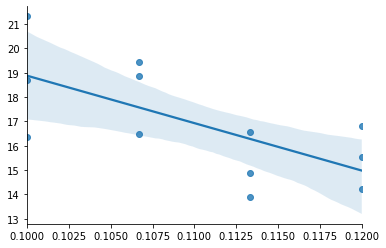

In [11]:
plot_x = grid.repeat(len(seeds))
plot_y = np.array([res["value"] for res in results])
sns.regplot(x=plot_x, y=plot_y, order=1)


<AxesSubplot:>

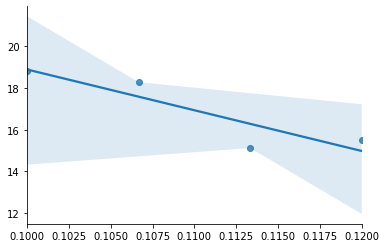

In [12]:
mean_plot_x = plot_x.reshape(-1, len(seeds)).mean(axis=1)
mean_plot_y = plot_y.reshape(-1, len(seeds)).mean(axis=1)
sns.regplot(x=mean_plot_x, y=mean_plot_y, order=1)

In [13]:
best_index = mean_plot_y.argmin()
best_x_value = grid[best_index]
best_avg_value = mean_plot_y[best_index]
relevant_msm_results = [res for i, res in enumerate(results) if plot_x[i] == best_x_value]
best_x_value

0.11333333333333333

In [14]:
combined_result = {
    "empirical_moments": relevant_msm_results[0]["empirical_moments"],
    "simulated_moments": [res["simulated_moments"] for res in relevant_msm_results],
}
    

In [15]:
best_avg_value

15.122634399582367

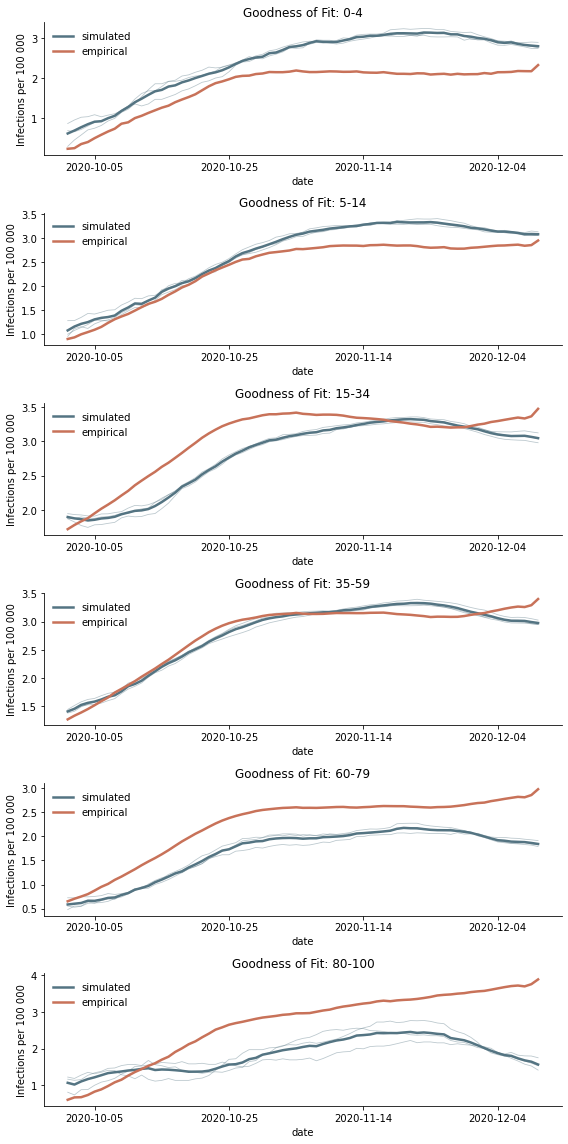

In [16]:
fig, ax = plot_msm_performance(combined_result)

In [17]:
combined_result["empirical_moments"]["infections_by_age_group"]

(Timestamp('2020-10-01 00:00:00', freq='D'), '0-4')       0.242047
(Timestamp('2020-10-01 00:00:00', freq='D'), '15-34')     1.716175
(Timestamp('2020-10-01 00:00:00', freq='D'), '35-59')     1.271565
(Timestamp('2020-10-01 00:00:00', freq='D'), '5-14')      0.898949
(Timestamp('2020-10-01 00:00:00', freq='D'), '60-79')     0.652178
                                                            ...   
(Timestamp('2020-12-10 00:00:00', freq='D'), '15-34')     3.474183
(Timestamp('2020-12-10 00:00:00', freq='D'), '35-59')     3.399571
(Timestamp('2020-12-10 00:00:00', freq='D'), '5-14')      2.951124
(Timestamp('2020-12-10 00:00:00', freq='D'), '60-79')     2.976327
(Timestamp('2020-12-10 00:00:00', freq='D'), '80-100')    3.884873
Length: 426, dtype: float64

In [18]:
def plot_aggregated_msm_performance(iteration, logs=True):
    """Plot the moment performance contrasting empirical and simulated moments.
    Args:
        iteration (dict): estimagic optimization iteration
    Returns:
        fig, axes
    """
    colors = get_colors(palette="categorical", number=2)

    fig, ax = plt.subplots(figsize=(8, 5))

    key = "infections_by_age_group"

    emp_mom = _convert_to_dataframe_with_age_groups_as_columns(
        iteration["empirical_moments"][key]
    )
    
    age_group_info = pd.read_pickle(
        BLD / "data" / "population_structure" / "age_groups_rki.pkl"
    )
    age_weights = age_group_info["weight"]
    
    aggregated_emp_mom = (emp_mom * age_weights).sum(axis=1)
    
    sim_moms = [mom[key] for mom in iteration["simulated_moments"]]
    mean_agg_sim_mom = (_convert_to_dataframe_with_age_groups_as_columns(
        pd.concat(sim_moms, axis=1).mean(axis=1)) * age_weights).sum(axis=1)

    
    agg_sim_moms = [(_convert_to_dataframe_with_age_groups_as_columns(mom) * age_weights).sum(axis=1) for mom in sim_moms]
    
    for mom in agg_sim_moms:
            
        sns.lineplot(
            x=mom.index,
            y=mom,
            color=colors[0],
            alpha=0.4,
            linewidth=0.8,
            ax=ax,
        )


    sns.lineplot(
        x=aggregated_emp_mom.index,
        y=aggregated_emp_mom,
        label="empirical",
        color=colors[1],
        ax=ax,
        linewidth=2.5,
    )

    sns.lineplot(
        x=mean_agg_sim_mom.index,
        y=mean_agg_sim_mom,
        label="simulated",
        color=colors[0],
        ax=ax,
        linewidth=2.5,
    )
    ax.set_title(f"Goodness of Fit")
    ax.set_ylabel("Infections per 100 000")

    ax.xaxis.set_major_locator(plt.MaxNLocator(8))

    fig.tight_layout()

    return fig, ax
    

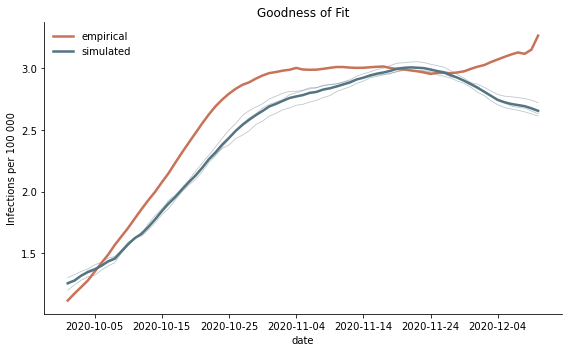

In [19]:
fig, ax = plot_aggregated_msm_performance(combined_result)